# Tutorial 5: Labor search

The most-requested feature of SSJ toolkit v0.1 has been support for time-varying transition matrices for exogenous states in HA blocks. This is needed, for example, for models in which the probability of becoming unemployed varies with the business cycle. This feature is supported by HetBlocks in 1.0.0 and newer versions of the toolkit. In this notebook, we show how to implement it. 

In [86]:
import numpy as np
import matplotlib.pyplot as plt

## 1 Model setup

Consider a simple incomplete markets model with unemployment risk. The state variables are 
- employment status $s \in \{E, U\}$
- labor productivity $e \in \{e_1, \dots, e_m\}$
- liquid assets $a \in [\underline{a}, \infty)$ 

Employment status matters for income. Employed workers earn wage $w_t e$, while unemployed workers receive benefits $b e.$ Let $y_t(s, e)$ denote this non-financial income.

From the workers' perspective, employment status evolves exogenously. An employed worker may lose her job with probability $\sigma_t$. An unemployed worker may find a job with probability $f_t.$ Let $\Pi_t^s$ denote the Markov matrix associated with state $s$. Of course, these transition probabilities may be determined endogenously outside the HetBlock, e.g. in a search and matching block.

The Bellman equation is
$$
\begin{align*}
V_t(s, e, a_{-}) = \max_{c, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t\left[V_{t+1}(s', e', a)|s, e \right] \right\}
\\
c + a &= (1 + r_t)a_{-} + y_t(s, e)
\\
a &\geq \underline{a}
\end{align*}
$$

## 2 设置HA模块

从版本1.0.0开始，HetBlocks支持任意数量的离散外生状态变量。唯一的限制在于时间安排。我们假设，当代理人选择他们的内生状态（在本例中为资产$a$）时，所有的离散冲击已经解决。贝尔曼方程反映了这一时间假设。相关的状态是`(s, e, a_{-})`，即`(s, e)`来自当前周期，而`a_{-}`来自上一周期。

对外生状态的期望（向后迭代）和分布的运动规律（向前迭代）需要一些特定的时间假设。HetBlock需要知道如何处理这些。我们选择的时间假设（决策前的离散冲击）是宏观模型中最常见的。

在这种范式下，我们处理的HA问题只是我们在Krusell-Smith模型中使用的SIM模型的一个特例。相比`sequence_jacobian/examples/hetblocks/household_sim`，我们只需要做3个小的改动：
1. 确保numpy表达式适用于三维数组（状态空间是`(s, e, a)`，而不是`(e, a)`）。
2. 按*时间顺序*提供`exogenous`马尔可夫矩阵的名称。
3. 编写hetinput函数，将就业率和离职率映射到马尔可夫矩阵$\Pi_t^s$。

完成这些后，一切将按预期运行。我们可以对$f_t$进行冲击并计算雅可比矩阵等。

#### Step 1: hetinputs 

In [87]:
from sequence_jacobian import markov_rouwenhorst, agrid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    """to discretize the income states and asset grids"""
    e_grid, _, Pi_e = markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi_e, a_grid


def search_frictions(f, s):
    """the employment state transition matrix"""
    Pi_s = np.vstack(([1 - s, s], [f, 1 - f]))
    return Pi_s


def labor_income(e_grid, w, b):
    """non-financial income given employment and endowment"""
    y = np.vstack((w * e_grid, b * e_grid))
    return y 

#### Step 2: core HA block

In [88]:
from sequence_jacobian import het, interpolate_y

def household_init(a_grid, y, r, eis):
    c = np.maximum(1e-8, y[..., np.newaxis] + np.maximum(r, 0.04) * a_grid)
    Va = (1 + r) * (c ** (-1 / eis))
    return Va

@het(exogenous=['Pi_s', 'Pi_e'], policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, y, r, beta, eis):
    """the HetBlock with normal egm method"""
    c_nextgrid = (beta * Va_p) ** (-eis)
    coh = (1 + r) * a_grid + y[..., np.newaxis]
    a = interpolate_y(c_nextgrid + a_grid, coh, a_grid)  # (x, xq, y)
    a = np.maximum(a, a_grid[0]) 
    c = coh - a
    uc = c ** (-1 / eis)
    Va = (1 + r) * uc

    return Va, a, c

#### Step 4: hetoutputs

Let's report the unemployment rate.

In [89]:
def unemployment(c):
    u = np.zeros_like(c)
    u[1, ...] = 1.0
    return u

#### Step 4: assemble HA block

In [90]:
hh = household.add_hetinputs([make_grid, search_frictions, labor_income])
hh = hh.add_hetoutputs([unemployment])

print(hh)
print(f'Inputs: {hh.inputs}')
print(f'Macro outputs: {hh.outputs}')
print(f'Micro outputs: {hh.internals}')

<HetBlock 'household' with hetinput 'search_frictions_labor_income' and with hetoutput `unemployment'>
Inputs: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'f', 's', 'w', 'b']
Macro outputs: ['A', 'C', 'U']
Micro outputs: ['D', 'Dbeg', 'Pi_s', 'Pi_e', 'Va', 'a', 'c', 'u', 'e_grid', 'a_grid', 'y']


## 3 Use HA block

Let's consider a baseline calibration and a shock to the separation rate.

In [91]:

calibration = dict(Z=1,beta=0.95, r=0.01, eis=0.5, f=0.4, s=0.1, w=1., b=0.5,
                   rho_e=0.95, sd_e=0.5, nE=5, amin=0., amax=50, nA=100,alpha = 0.33,delta =0.08,L = 1.0) 

ss = hh.steady_state(calibration)

d:\miniconda\Lib\site-packages\sequence_jacobian\__init__.py:30: UserWarning: Calling sj.markov_rouwenhorst() is deprecated and will be disallowed in a subsequent version.
Please call sj.grids.markov_rouwenhorst() instead.
d:\miniconda\Lib\site-packages\sequence_jacobian\__init__.py:25: UserWarning: The function 'agrid' is deprecated and will be removed in a subsequent version.
Please call sj.grids.asset_grid(amin, amax, n) instead.
d:\miniconda\Lib\site-packages\sequence_jacobian\__init__.py:40: UserWarning: Calling sj.interpolate_y() is deprecated and will be disallowed in a subsequent version.
Please call sj.interpolate.interpolate_y() instead.


In [92]:
ss.internals['household'].keys()

dict_keys(['Pi_s', 'e_grid', 'Pi_e', 'a_grid', 'y', 'a', 'c', 'Va', 'Dbeg', 'D', 'u'])

Let's plot consumption function of worker with average productivity in employment vs unemployment.

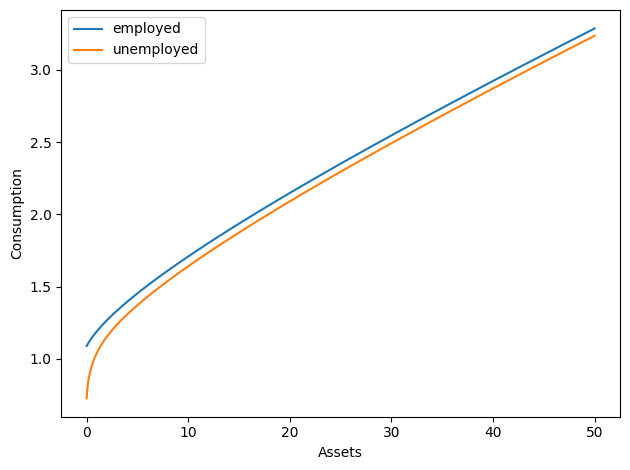

In [93]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'][0, 3, :], label='employed')
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['c'][1, 3, :], label='unemployed')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.legend()
plt.tight_layout()
plt.show()

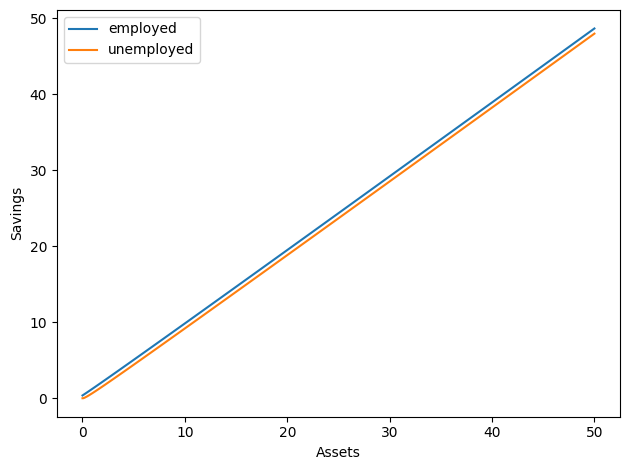

In [94]:
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['a'][0, 3, :], label='employed')
plt.plot(ss.internals['household']['a_grid'], ss.internals['household']['a'][1, 3, :], label='unemployed')
plt.xlabel('Assets')
plt.ylabel('Savings')
plt.legend()
plt.tight_layout()
plt.show()

Consider the impulse responses of consumption end employment to a persistent rise in the separation rate.

In [95]:
s_shock = {'s': 0.01 * 0.9 ** np.arange(50),'f':-0.01 * 0.9 ** np.arange(50)}
td = hh.impulse_linear(ss, s_shock)
td_nonlinear = hh.impulse_nonlinear(ss,s_shock)

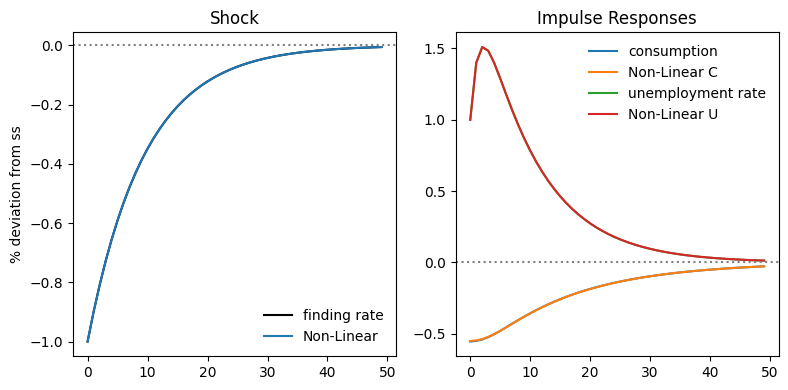

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].plot(100 * td['f'], color='black', label='finding rate')
ax[0].plot(100 * td_nonlinear['f'],label = 'Non-Linear')
ax[0].axhline(0, color='gray', linestyle=':')
ax[0].set_title('Shock')
ax[0].set_ylabel('% deviation from ss')
ax[0].legend(frameon=False)

ax[1].plot(100 *td['C'], label='consumption')
ax[1].plot(100 *td_nonlinear['C'],label = 'Non-Linear C')
ax[1].plot(100 *td['U'], label='unemployment rate')
ax[1].plot(100*td_nonlinear['U'], label='Non-Linear U')
ax[1].axhline(0, color='gray', linestyle=':')
ax[1].legend(frameon=False)
ax[1].set_title('Impulse Responses')
plt.tight_layout()
plt.show()